# Decision Tree

### Objectives:
- Going over the Advantages / Disadvantages of DT
- Classifying Iris data using a decision tree
- Fine-tuning a decision tree using Grid Search to improve its performance
- Comparing a decision tree with a random forest for digit classification problem
- Fine-tuning random forest using Grid Search
- Using decision tree and random forest models for regression problems


## Recap

1. What are advantages of DT?

<span style="color:blue"> Advantages:
- Simple to understand and to interpret. Trees can be visualized.
- Requires little data preparation. Other techniques often require data normalization, dummy variables need to be created and blank values to be removed. Note however that this module does not support missing values.
- The cost of using the tree (i.e., predicting data) is logarithmic in the number of data points used to train the tree.
- Able to handle both numerical and categorical data. However, the scikit-learn implementation does not support categorical variables for now. Other techniques are usually specialized in analyzing datasets that have only one type of variable. See algorithms for more information.
- Able to handle multi-output problems.
- Uses a white box model. If a given situation is observable in a model, the explanation for the condition is easily explained by boolean logic. By contrast, in a black box model (e.g., in an artificial neural network), results may be more difficult to interpret.

2. What are disadvantages of DT?

<span style="color:blue"> Disadvantages:

- Decision-tree learners can create over-complex trees that do not generalize the data well. This is called overfitting. Mechanisms such as pruning, setting the minimum number of samples required at a leaf node or setting the maximum depth of the tree are necessary to avoid this problem.
- Decision trees can be unstable because small variations in the data might result in a completely different tree being generated. This problem is mitigated by using decision trees within an ensemble.
- Decision tree learners create biased trees if some classes dominate. It is therefore recommended to balance the dataset prior to fitting with the decision tree.

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. 

In [1]:
# Scikit-Learn ≥0.20 is required
import sklearn

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# DecisionTreeClassifier Class


For this lab we will use the DecisionTreeClassifier class of sklearn. Please read more about this class at https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

# Loading the Iris Data and Training a Decision Tree

- The iris dataset is a famous machine learning dataset that contains information about the sepal and petal dimensions of three species of iris flowers: setosa, versicolor, and virginica. The dataset is often used as a teaching tool in machine learning and data science courses, and is also commonly used for data analysis and predictive modeling.

- The dataset contains 150 observations of iris flowers, with 50 observations for each of the three species. For each observation, the dataset records four measurements: sepal length, sepal width, petal length, and petal width.

- The goal of the dataset is to classify each observation into one of the three species of iris flower based on the four measurements. The iris dataset is a classic example of a multi-class classification problem in machine learning, where the goal is to classify each observation into one of several classes (in this case, three species of flower).

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width -- we are using only two features
y = iris.target

tree_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth=2, random_state=42)
tree_clf.fit(X, y)

,criterion,'entropy'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In order to visualize the decision tree that we just trained, we will use the graphviz. We will generate the .dot file, and then copy its contents to http://www.webgraphviz.com to visualize the tree. The resulting tree will look something like shown below. 

In [3]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

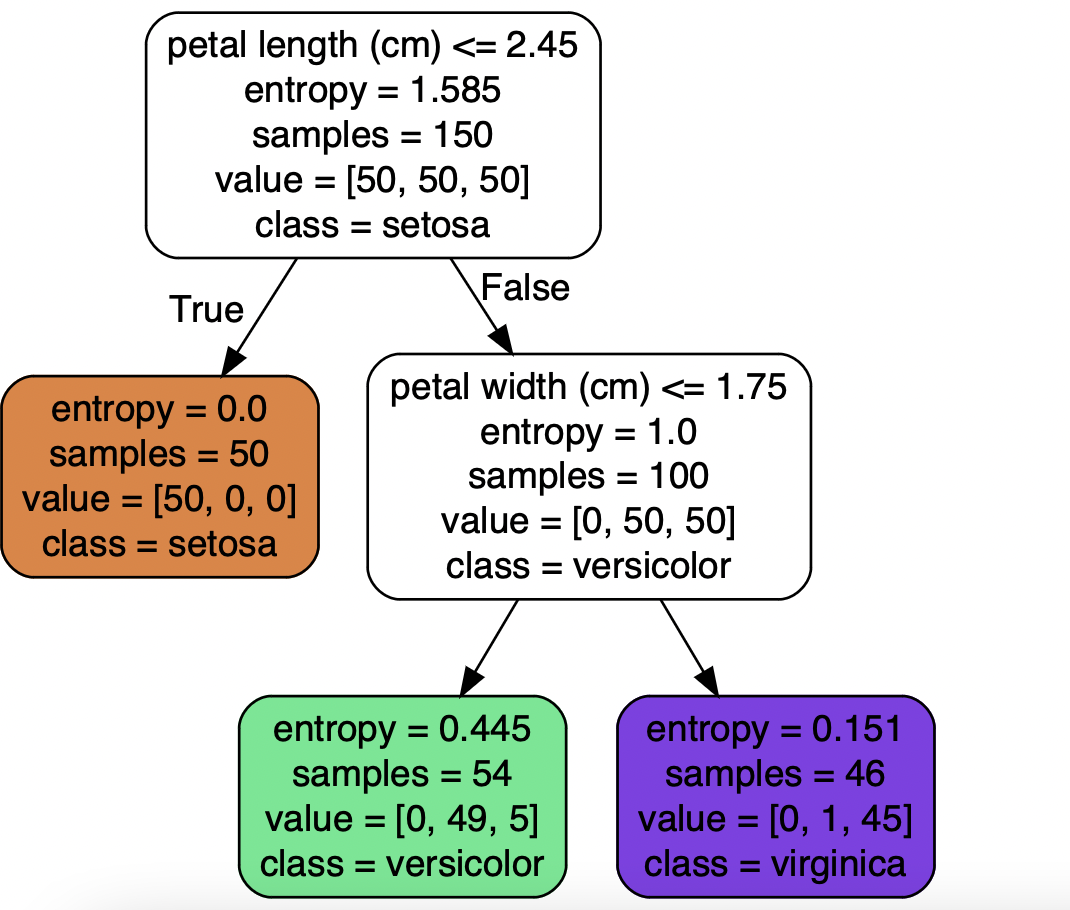

The above tree was fit on the entire data. Let's split the data between training and testing data, fit the tree on the training data with all features and test it on the test data

In [4]:
from sklearn.model_selection import train_test_split

X, y = iris.data, iris.target

train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

dt_clf = DecisionTreeClassifier(criterion = 'entropy', max_depth =2, random_state=42)

#train the the decision tree on the train_x train_y train sets
dt_clf = dt_clf.fit(train_x, train_y)

score = dt_clf.score(test_x, test_y)
print(score)

0.9666666666666667


As you can see, within a few lines we can train the Decision Tree classifier. Also, pay attention that we did not spend any effort on data preparation (i.e. converting labels into one-hot encoding etc.)
We can also have more understanding of the performance of our decision tree model by building a text report showing the rules of a decision tree.

In [5]:
from sklearn.tree import export_text
r = export_text(dt_clf, feature_names=iris['feature_names'])
print(r)

|--- petal length (cm) <= 2.45
|   |--- class: 0
|--- petal length (cm) >  2.45
|   |--- petal length (cm) <= 4.75
|   |   |--- class: 1
|   |--- petal length (cm) >  4.75
|   |   |--- class: 2



### Q / A
1.  What do leaves and branches represent in Decision trees?
<span style="color:blue">Leaves represent class labels and branches represent conjunctions of features that lead to those class labels. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

2. When do we stop splitting the tree?
<span style="color:blue">Either samples at each node all belong to the same class, or we have met a stopping criteria.

3. What is Entropy?
<span style="color:blue">It is the measure of impurity or randomness in the data points.

4. What is Information Gain?
<span style="color:blue">Information Gain is applied to quantify which feature provides maximal information about the classification based on the notion of entropy, i.e. by quantifying the size of uncertainty, disorder or impurity, in general, with the intention of decreasing the amount of entropy initiating from the top (root node) to bottom(leaves nodes).

# Overfitting in Decision Trees

- Below we will create a simple classification problem having two features and fit two decision trees to this data. The first decision tree will have no restriction on its size or depth, whereas the other one will have a stopping criteria of having at least 4 data points in a leaf node. We will fit both trees and then visualize the class boundaries produced by them. 

- For visualization, we have defined a function plot_decision_boundary, which will show us the classifcation boundaries that a decision tree learns. Don't worry if you do no understand the code of this function. The aim is to use it to see how two trees with different complexities will differ when trained on the same data

In [6]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

Saving figure min_samples_leaf_plot


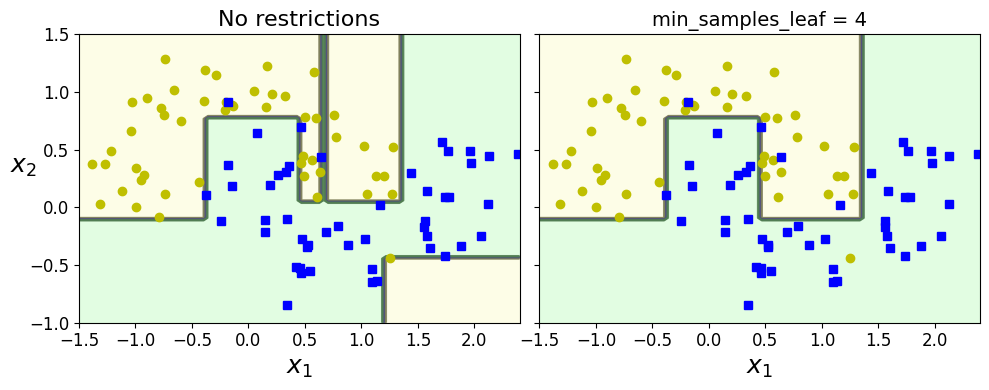

In [7]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("")

save_fig("min_samples_leaf_plot")
plt.show()

We can clearly see that the class boundaries learned by the first tree are way too complex as compared to the simple tree, which is much more suitable from the generalization point of view where want our model to not overfit and perform well on unseen data. 

# GridSearchCV Class

- Below, we will Use grid search with cross-validation (with the help of the GridSearchCV class) to learn how to find good hyperparameter values for a DecisionTreeClassifier. 

- In this example, we will try various values for max_leaf_nodes. Please read more about GridSearchCV at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

- Also note that we will use the make_moons function is a utility function provided by the Scikit-learn (sklearn) library that generates a toy dataset of two interleaving half circles. It is often used as a toy example in machine learning and data science to demonstrate various concepts

In [8]:
from sklearn.model_selection import GridSearchCV

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

params = {'max_leaf_nodes': list(range(2, 10)), 'min_samples_split': [2, 3]}
grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=42), params, verbose=1, cv=3)

grid_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


,estimator,DecisionTreeC...ndom_state=42)
,param_grid,"{'max_leaf_nodes': [2, 3, ...], 'min_samples_split': [2, 3]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [9]:
grid_search_cv.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,4
,min_impurity_decrease,0.0
,class_weight,None


The result from Grid Search CV in this case indicates that the best hyperparameters for the DecisionTreeClassifier are max_leaf_nodes=4

# Random Forests

Please read about the RandomForestClassifier class at https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

- In this part, we will use the load_digits function, which is a utility function provided by the Scikit-learn (sklearn) library that loads a pre-existing dataset of grayscale images of handwritten digits. It is often used as a toy example in machine learning and data science to demonstrate various concepts.

- We will classify this data using both a decision tree and a RandomForest and compare their performance. 

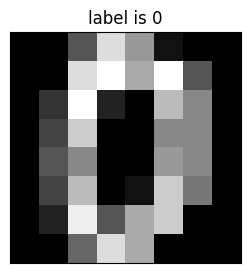

In [10]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


plt.figure(1, figsize=(3, 3))
plt.imshow(X[0].reshape((8,8)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"label is {y[0]}")
plt.show()

### Single decision tree

First, we train a single decision tree.

In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", tree_score)

Single tree accuracy: 0.8501683501683501


### Random Forest for MNIST

Next, we train a random forest for the same problem and see if we get better results than a single decision tree.

In [12]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rnd_clf.fit(X_train, y_train)

pred = rnd_clf.predict(X_test)

rf_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", rf_score)

Single tree accuracy: 0.9107744107744108


As expected, we got much better prediction performance using the random forest model

# Challenge Activity

1. Use the GridSearchCV class below to fine tune the hyper parameters of the random forest model from the above digit classifcation problem.

2. As we learned, we can use decision tree and random forest for both classification and regression problems. Read about the DecisionTreeRegressor and RandomForestRegressor classes at https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html and https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html, respectively. 